In [1]:
# common imports 
import pandas as pd
import numpy as np

from tqdm import tqdm
import time
import os

# for date and time
from datetime import datetime 
import holidays

# graphs
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

In [2]:
# pytorch imports
import torch
import torch.nn as nn

# torch dataloaders
import torch.functional as f
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split

## Creating Dataset

In [3]:
data = pd.read_csv('rnn_dataset.csv')
data.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [5]:
data.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


In [6]:
new_features = [ data.loc[i-100:i, 'PJMW_MW'] for i in range(100,len(data)) ]
new_label =  np.array( data.loc[100:, 'Datetime'] ).reshape(-1,1)

In [7]:
data.loc[ 100 ]

Datetime    2002-12-27 05:00:00
PJMW_MW                  5485.0
Name: 100, dtype: object

In [8]:
new_label[0]

array(['2002-12-27 05:00:00'], dtype=object)

In [9]:
# example :
new_features[0]

0      5077.0
1      4939.0
2      4885.0
3      4857.0
4      4930.0
        ...  
96     5628.0
97     5467.0
98     5402.0
99     5367.0
100    5485.0
Name: PJMW_MW, Length: 101, dtype: float64

In [10]:
new_df_features = np.array(new_features)
( new_df_features.shape, new_label.shape )

((143106, 101), (143106, 1))

**100** features with the no of rows as 143106 

In [11]:
new_data = np.append( new_label, new_df_features, axis = 1)

In [12]:
new_data.shape

(143106, 102)

In [13]:
# example
new_data[0]

array(['2002-12-27 05:00:00', 5077.0, 4939.0, 4885.0, 4857.0, 4930.0,
       5126.0, 5493.0, 5824.0, 5962.0, 6019.0, 5988.0, 5885.0, 5764.0,
       5612.0, 5486.0, 5474.0, 5668.0, 6027.0, 5973.0, 5772.0, 5547.0,
       5358.0, 5143.0, 4931.0, 5340.0, 5225.0, 5317.0, 5310.0, 5403.0,
       5666.0, 6014.0, 6360.0, 6497.0, 6555.0, 6490.0, 6336.0, 6255.0,
       6220.0, 6144.0, 6108.0, 6250.0, 6659.0, 6710.0, 6638.0, 6491.0,
       6267.0, 5885.0, 5469.0, 5246.0, 5073.0, 5043.0, 4984.0, 4997.0,
       5081.0, 5200.0, 5389.0, 5614.0, 5767.0, 5750.0, 5712.0, 5715.0,
       5549.0, 5427.0, 5383.0, 5651.0, 6178.0, 6364.0, 6339.0, 6269.0,
       6167.0, 5953.0, 5639.0, 5714.0, 5543.0, 5460.0, 5414.0, 5465.0,
       5577.0, 5778.0, 5959.0, 6167.0, 6323.0, 6342.0, 6256.0, 6178.0,
       6073.0, 6006.0, 5962.0, 6107.0, 6462.0, 6522.0, 6426.0, 6359.0,
       6167.0, 5868.0, 5524.0, 5628.0, 5467.0, 5402.0, 5367.0, 5485.0],
      dtype=object)

### dataset - 1

In [14]:
# Creating the new dataframe

rnn_data = pd.DataFrame( new_data , columns = ['label'] + list(range(1,101) ) + ['target']  )
rnn_data.head()

,label,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,target
0,2002-12-27 05:00:00,5077.0,4939.0,4885.0,4857.0,4930.0,5126.0,5493.0,5824.0,5962.0,...,6426.0,6359.0,6167.0,5868.0,5524.0,5628.0,5467.0,5402.0,5367.0,5485.0
1,2002-12-27 06:00:00,4939.0,4885.0,4857.0,4930.0,5126.0,5493.0,5824.0,5962.0,6019.0,...,6359.0,6167.0,5868.0,5524.0,5628.0,5467.0,5402.0,5367.0,5485.0,5695.0
2,2002-12-27 07:00:00,4885.0,4857.0,4930.0,5126.0,5493.0,5824.0,5962.0,6019.0,5988.0,...,6167.0,5868.0,5524.0,5628.0,5467.0,5402.0,5367.0,5485.0,5695.0,6069.0
3,2002-12-27 08:00:00,4857.0,4930.0,5126.0,5493.0,5824.0,5962.0,6019.0,5988.0,5885.0,...,5868.0,5524.0,5628.0,5467.0,5402.0,5367.0,5485.0,5695.0,6069.0,6365.0
4,2002-12-27 09:00:00,4930.0,5126.0,5493.0,5824.0,5962.0,6019.0,5988.0,5885.0,5764.0,...,5524.0,5628.0,5467.0,5402.0,5367.0,5485.0,5695.0,6069.0,6365.0,6569.0


In [15]:
train, val, y_train, y_val = train_test_split( rnn_data.drop(['label','target'], axis = 1, inplace = False ),
                                               rnn_data['target'], 
                                               test_size = 0.15,
                                               shuffle = True,
                                               random_state = 12
                                               )

train, test, y_train, y_test  = train_test_split( train, 
                                                y_train, 
                                                test_size = 15/85,
                                                shuffle = True,
                                                random_state = 12
                                               )

In [16]:
print(f" percentage of train data : {len(train)/len(rnn_data)*100:.2f} %")
print(f" percentage of test data : {len(test)/len(rnn_data)*100:.2f} %")
print(f" percentage of val data : {len(val)/len(rnn_data)*100:.2f} %")

 percentage of train data : 70.00 %
 percentage of test data : 15.00 %
 percentage of val data : 15.00 %


In [17]:
np.array(train).shape

(100174, 100)

### dataset - 2

In [18]:
data['Datetime'][25]

'2002-12-30 02:00:00'

In [19]:
print( 'example : ' , datetime.strptime( data['Datetime'][45], '%Y-%m-%d %H:%M:%S' ).hour )

day = []
month = []
weekday = []
week = []
hr = []
holiday = []

us_holidays = holidays.US()

for i in [ datetime.strptime( i ,'%Y-%m-%d %H:%M:%S' ) for i in data['Datetime'] ] :

    day.append( i.day )
    month.append( i.month )
    hr.append( i.hour )
    week.append( i.isocalendar().week )
    weekday.append( i.weekday() )
    holiday.append( int(i in us_holidays ) )

example :  22


In [20]:
data_2 = pd.DataFrame( {'label' : data['Datetime'], 'hour' : hr, 'day' : day, 'weekday' : weekday ,'week' : week, 'month' : month, 'holiday' : holiday, 'target' : data['PJMW_MW'] } )
data_2.head()

,label,hour,day,weekday,week,month,holiday,target
0,2002-12-31 01:00:00,1,31,1,1,12,0,5077.0
1,2002-12-31 02:00:00,2,31,1,1,12,0,4939.0
2,2002-12-31 03:00:00,3,31,1,1,12,0,4885.0
3,2002-12-31 04:00:00,4,31,1,1,12,0,4857.0
4,2002-12-31 05:00:00,5,31,1,1,12,0,4930.0


In [603]:
## Normalization
normalizer = OneHotEncoder()
rnn_data_2 = pd.DataFrame( normalizer.fit_transform( data_2.drop(['target', 'label'], axis = 1, inplace = False) ).toarray() )
rnn_data_2['label'] = data['Datetime']
rnn_data_2['target'] = data['PJMW_MW']

In [22]:
rnn_data_2 = data_2
rnn_data_2.head()

,label,hour,day,weekday,week,month,holiday,target
0,2002-12-31 01:00:00,1,31,1,1,12,0,5077.0
1,2002-12-31 02:00:00,2,31,1,1,12,0,4939.0
2,2002-12-31 03:00:00,3,31,1,1,12,0,4885.0
3,2002-12-31 04:00:00,4,31,1,1,12,0,4857.0
4,2002-12-31 05:00:00,5,31,1,1,12,0,4930.0


In [23]:
train_2, val_2, y_train_2, y_val_2 = train_test_split( rnn_data_2.drop(['label','target'], axis = 1, inplace = False ),
                                               rnn_data_2['target'], 
                                               test_size = 0.15,
                                               shuffle = True,
                                               random_state = 16
                                               )

train_2, test_2, y_train_2, y_test_2  = train_test_split( train_2, 
                                                y_train_2, 
                                                test_size = 15/85,
                                                shuffle = True,
                                                random_state = 16
                                               )

In [24]:
print(f" percentage of train data : {len(train_2)/len(rnn_data_2)*100:.2f} %")
print(f" percentage of test data : {len(test_2)/len(rnn_data_2)*100:.2f} %")
print(f" percentage of val data : {len(val_2)/len(rnn_data_2)*100:.2f} %")

 percentage of train data : 70.00 %
 percentage of test data : 15.00 %
 percentage of val data : 15.00 %


In [25]:
train_2.shape

(100244, 6)

### dataloader

In [26]:
class Create_Dataset(Dataset):

    def __init__(self, data, target):
        self.data = data.reshape(len(data) ,-1, 1 ) 
        self.target = target.reshape(-1,1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype = torch.float32), torch.tensor(self.target[index], dtype = torch.float32)

# For Dataset - 1

train_dataset = Create_Dataset(data = np.array(train, dtype = np.float32), target = np.array(y_train, dtype = np.float32))
val_dataset = Create_Dataset(data = np.array(val, dtype = np.float32), target = np.array(y_val, dtype = np.float32))
test_dataset = Create_Dataset(data = np.array(test, dtype = np.float32), target = np.array(y_test, dtype = np.float32))

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True, drop_last = False)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = True, drop_last = False)
val_dataloader = DataLoader(val_dataset, batch_size = 16, shuffle = True, drop_last = False)

In [27]:
for i in train_dataloader:
    print(i[0].shape, i[1].shape)
    break

torch.Size([16, 100, 1]) torch.Size([16, 1])


In [28]:
# For Dataset - 1

train_dataset_2 = Create_Dataset(data = np.array(train_2, dtype = np.float32), target = np.array(y_train_2, dtype = np.float32))
val_dataset_2 = Create_Dataset(data = np.array(val_2, dtype = np.float32), target = np.array(y_val_2, dtype = np.float32))
test_dataset_2 = Create_Dataset(data = np.array(test_2, dtype = np.float32), target = np.array(y_test_2, dtype = np.float32))

train_dataloader_2 = DataLoader(train_dataset_2, batch_size = 16, shuffle = True, drop_last = False)
test_dataloader_2 = DataLoader(test_dataset_2, batch_size = 16, shuffle = True, drop_last = False)
val_dataloader_2 = DataLoader(val_dataset_2, batch_size = 16, shuffle = True, drop_last = False)

In [29]:
for i in train_dataloader_2:
    print(i[0].shape, i[1].shape)
    break

torch.Size([16, 6, 1]) torch.Size([16, 1])


## Creating Model

In [30]:
def R2_Score(pred, target):
    pred = pred.detach().cpu().numpy().reshape(-1)
    target = target.detach().cpu().numpy().reshape(-1)
    return r2_score(target, pred)*100

In [31]:
class RNN_model(nn.Module):

    def __init__(self, input_dim = 1 , hidden_dim = 256, output_dim = 1, num_layers = 1):

        super(RNN_model, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.dense_layer = nn.Sequential(

            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            
            nn.Linear(self.hidden_dim, self.output_dim),
        )

        self.rnn_layer = nn.RNN(
            self.input_dim, self.hidden_dim, num_layers = self.num_layers, nonlinearity = 'tanh', bias = True , batch_first = True
        )
        
    
    def initialize_h0(self, dim, device):
        self.h0  =  torch.zeros(self.num_layers, dim ,self.hidden_dim, requires_grad= True, dtype = torch.float32 ).to(device)
        # print( self.h0.size() )
    
    def forward(self, input, ):
        # print(input.shape)
        
        self.initialize_h0( input.size(0) , device = input.device )
        out, hn = self.rnn_layer( input , self.h0 )

        if self.dense_layer is not None:
            output = self.dense_layer( hn[0] )
        else: output = hn
        
        return output


### Creating trainer

In [32]:
# hyper parameters:

lr = 1e-4
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 768

optimizer = torch.optim.Adam
optimizer_params = {'lr' : lr, }

In [33]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, drop_last = False)

print(f" There are total '{len(train_dataloader)}' batches in train data 1 ")

 There are total '131' batches in train data 1 


In [34]:
class RNN_Trainer():

    def __init__(self, name, model, optimizer = optimizer , optimizer_params = optimizer_params, train_dataloader = train_dataloader, test_dataloader = test_dataloader, val_dataloader = val_dataloader,):

        # initializing models
        self.name = name
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer_params = optimizer_params

        self.train_len  =  len(train)
        self.validation_len = len(val)

        # optimizers and loss fn
        self.optimizer = optimizer(self.model.parameters(), **self.optimizer_params)
        self.loss = nn.MSELoss()
    
    def eval(self, evaluation_fn = R2_Score ):

        epoch_loss = 0
        epoch_metric = 0

        with torch.cuda.amp.autocast() and torch.no_grad() :

            for index,batch in tqdm( enumerate(self.val_dataloader), total = len(self.val_dataloader), desc = 'val epoch progress' ):

                    data,target = batch

                    # changing type and data type of the image to ensure computability
                    data = data.to(device).type(torch.float32)
                    target = target.to(device).type(torch.float32)

                    # getting the prediction from the model
                    pred = self.model(data)

                    # computing loss
                    Loss = self.loss(pred, target)

                    # calculating loss
                    epoch_loss += Loss.item()*len(data)
                    epoch_metric += evaluation_fn( pred , target )*len(data)
        
        return epoch_loss/self.validation_len , epoch_metric/self.validation_len

    def train_model(self, epochs = 100, print_freq = 10, save_freq = 500, evaluation_fn =  R2_Score ):

        train_loss = []
        train_metric = []

        val_loss = []
        val_metric = []

        # with torch.cuda.amp.autocast():

        if epochs > 0:

            for e in range(epochs):

                epoch_loss = 0
                epoch_metric = 0

                loop_obj = tqdm( enumerate(self.train_dataloader), total = len(self.train_dataloader), desc = 'train epoch progress' )

                for index,batch in loop_obj:

                    data,target = batch

                    # zero_grad optimizer to erase previous gradients
                    self.optimizer.zero_grad()

                    # changing type and data type of the data to ensure computability
                    data = data.to(device).type(torch.float32)
                    target = target.to(device).type(torch.float32)

                    # getting the prediction from the model
                    pred = self.model(data)

                    # computing loss
                    Loss = self.loss(pred, target)

                    # raise Exception(f" Checking the size of the loss : {Loss} ")
                    loop_obj.set_description(f" Train Loss is : {Loss} ", refresh = True)

                    # updating weights
                    Loss.backward()
                    self.optimizer.step()

                    # calculating loss
                    epoch_loss += Loss.item()*len(data)
                    epoch_metric += evaluation_fn( pred, target )*len(data)
                
                # Now storing the Loss and metric of every epoch
                train_loss.append( epoch_loss/self.train_len )
                train_metric.append( epoch_metric/self.train_len )

                # Now storing the value of val loss and val metric
                validation_data = self.eval()

                # Now storing them in the validation history
                val_loss.append(validation_data[0])
                val_metric.append(validation_data[1])

                if (e+1) % print_freq == 0  :

                    print(f"\n=====================================================")
                    print(f" The current epoch is : {e+1}")
                    print(f" Train Loss is : {train_loss[-1]:.3f}")
                    print(f" Train R2 Score is : {train_metric[-1]:.3f}")
                    print(f" Validation Loss is : {validation_data[0]:.3f}")
                    print(f" Validation R2 Score is : {validation_data[1]:.3f}")
                    print(f"=====================================================\n")
                
                if (e+1) % save_freq == 0  :
                    print(f"\n Model got saved in epoch : {e} ")
                    torch.save(self.model.state_dict(), f'saved_model/{self.name}/{e}.pt')
             
        return [np.array(train_loss), train_metric, np.array(val_loss), val_metric]
    
    
    def plot_data(self, train_loss, train_metric, val_loss, val_metric,):
        
        plt.figure(figsize = (20,18) )

        plt.subplot(3,2,1)

        plt.plot(train_loss, label = f'train_loss - MSE Loss')
        plt.title(f'train loss ')
        plt.xlabel('epochs')
        plt.ylabel('train_loss')
        plt.legend(loc = 'best')

        plt.subplot(3,2,2)

        plt.plot(val_loss, label = f'val_loss - MSE loss')
        plt.title(f'val loss ')
        plt.xlabel('epochs')
        plt.ylabel('val_loss')
        plt.legend(loc = 'best')

        plt.subplot(3,2,3)

        plt.plot(train_loss**0.5, label = f'train_loss - RMSE Loss')
        plt.title(f'train loss ')
        plt.xlabel('epochs')
        plt.ylabel('train_loss')
        plt.legend(loc = 'best')

        plt.subplot(3,2,4)

        plt.plot(val_loss**0.5, label = f'val_loss - RMSE loss')
        plt.title(f'val loss ')
        plt.xlabel('epochs')
        plt.ylabel('val_loss')
        plt.legend(loc = 'best')

        plt.subplot(3,2,5)

        plt.plot( np.clip( np.array(train_metric), -1, 100 ), label = f'train_metric - R2 score ')
        plt.title(f'train metric')
        plt.xlabel('epochs')
        plt.ylabel('train_metric')
        plt.legend(loc = 'best')

        plt.subplot(3,2,6)

        plt.plot( np.clip( np.array(val_metric) , -1, 100), label = f'val_metric - R2 score')
        plt.title(f'val metric')
        plt.xlabel('epochs')
        plt.ylabel('val_metric')
        plt.legend(loc = 'best')

        plt.show()


### training model - 1

In [435]:
RNN_Model_1 = RNN_model()
print(f" total params in the model is : {sum([p.numel() for p in RNN_Model_1.parameters() if p.requires_grad ])*1e-3:.3f} K")

# RNN_Model_1.load_state_dict(torch.load('saved_model\RNN_MODEL_1\9.pt', map_location=device))

 total params in the model is : 198.145 K


In [436]:
# example 
for i in train_dataloader:
    print( RNN_Model_1( i[0] ).shape )
    break

torch.Size([768, 1])


In [437]:
rnn_trainer = RNN_Trainer( 'RNN_MODEL_3', RNN_Model_1 )

In [438]:
history_data = rnn_trainer.train_model( epochs = 30 , print_freq = 5 )
rnn_trainer.eval()

val epoch progress: 100%|██████████| 28/28 [00:01<00:00, 24.16it/s]



 The current epoch is : 5
 Train Loss is : 9469049.039
 Train R2 Score is : -888.114
 Validation Loss is : 5719381.968
 Validation R2 Score is : -492.712


 Model got saved in epoch : 4 


val epoch progress: 100%|██████████| 28/28 [00:01<00:00, 24.19it/s]



 The current epoch is : 10
 Train Loss is : 863782.297
 Train R2 Score is : 9.895
 Validation Loss is : 804070.137
 Validation R2 Score is : 16.709


 Model got saved in epoch : 9 


val epoch progress: 100%|██████████| 28/28 [00:01<00:00, 24.07it/s]



 The current epoch is : 15
 Train Loss is : 204679.528
 Train R2 Score is : 78.665
 Validation Loss is : 170281.096
 Validation R2 Score is : 82.390


 Model got saved in epoch : 14 


val epoch progress: 100%|██████████| 28/28 [00:01<00:00, 24.10it/s]



 The current epoch is : 20
 Train Loss is : 66374.632
 Train R2 Score is : 93.085
 Validation Loss is : 63294.252
 Validation R2 Score is : 93.455


 Model got saved in epoch : 19 


val epoch progress: 100%|██████████| 28/28 [00:01<00:00, 24.20it/s]



 The current epoch is : 25
 Train Loss is : 40948.202
 Train R2 Score is : 95.727
 Validation Loss is : 41536.868
 Validation R2 Score is : 95.715


 Model got saved in epoch : 24 


val epoch progress: 100%|██████████| 28/28 [00:01<00:00, 23.84it/s]



 The current epoch is : 30
 Train Loss is : 34379.357
 Train R2 Score is : 96.412
 Validation Loss is : 35640.182
 Validation R2 Score is : 96.314


 Model got saved in epoch : 29 


val epoch progress: 100%|██████████| 28/28 [00:01<00:00, 24.17it/s]


(35640.18273829108, 96.3126387760968)

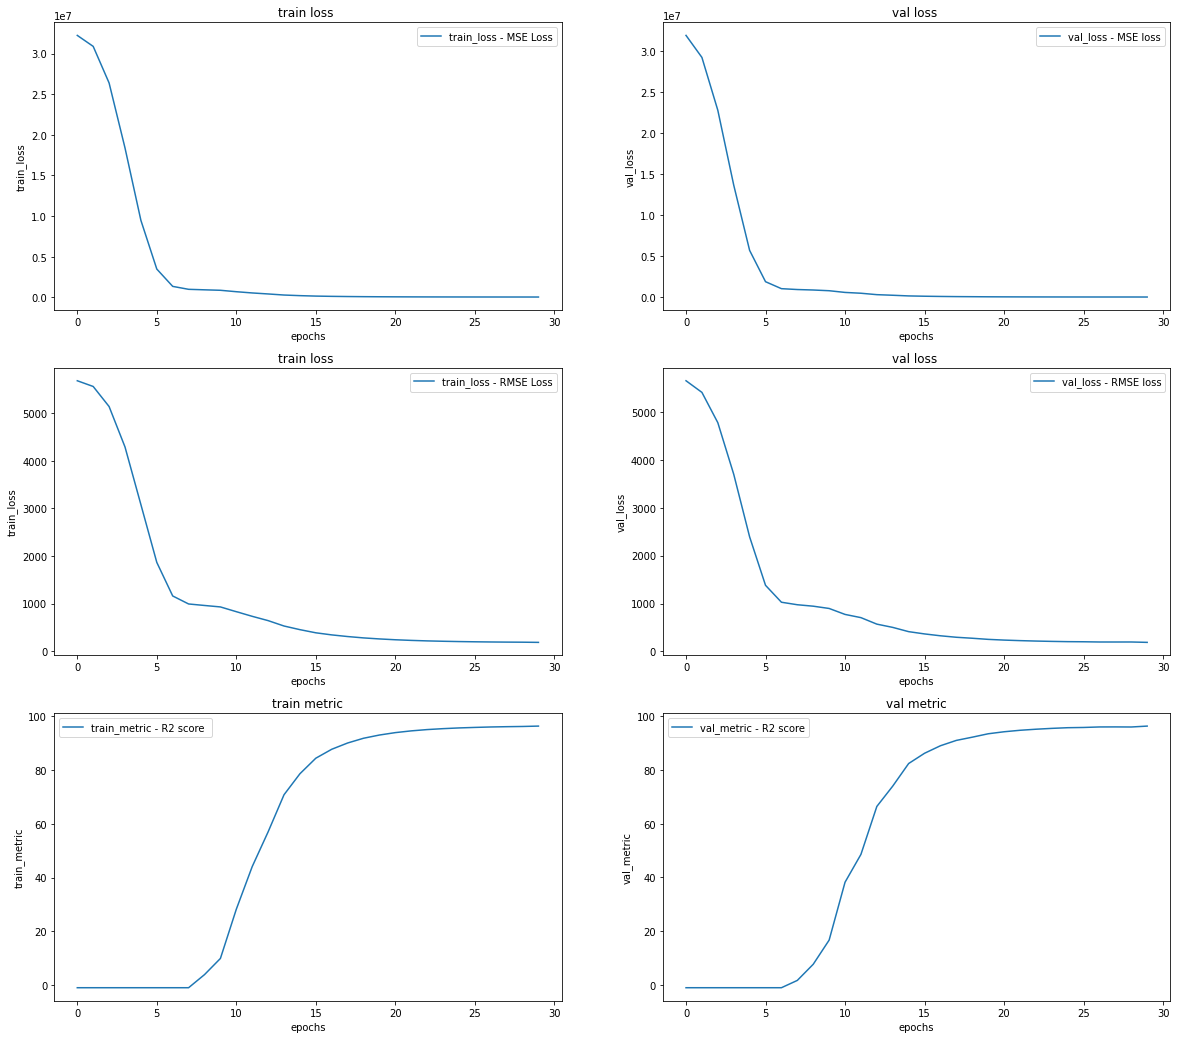

In [439]:
rnn_trainer.plot_data(*history_data)

### training model - 2

In [54]:
# hyper parameters:

lr_2 = 1e-7
epochs_2 = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size_2 = 1024

optimizer_2 = torch.optim.NAdam
optimizer_params_2 = {'lr' : lr_2, }

In [46]:
train_dataloader_2 = DataLoader(train_dataset_2, batch_size = batch_size_2, shuffle = True, drop_last = False)
test_dataloader_2 = DataLoader(test_dataset_2, batch_size = batch_size_2, shuffle = True, drop_last = False)
val_dataloader_2 = DataLoader(val_dataset_2, batch_size = batch_size_2, shuffle = True, drop_last = False)

In [47]:
print(f" There are total '{len(train_dataloader_2)}' batches in train data 2 ")

 There are total '98' batches in train data 2 


In [48]:
RNN_Model_2 = RNN_model()
print(f" total params in the model is : {sum([p.numel() for p in RNN_Model_2.parameters() if p.requires_grad ])*1e-3:.3f} K ")
# RNN_Model_2.load_state_dict(torch.load('saved_model\RNN_MODEL_2_DATA_2\\4.pt', map_location = device ))

 total params in the model is : 198.145 K 


In [55]:
rnn_trainer_2 = RNN_Trainer( 'RNN_MODEL_3_DATA_2', RNN_Model_2,  optimizer = optimizer_2 , optimizer_params = optimizer_params_2, train_dataloader = train_dataloader_2, test_dataloader = test_dataloader_2, val_dataloader = val_dataloader_2, )
rnn_trainer_2.validation_len = len(val_2)
rnn_trainer_2.train_len = len(train_2)

In [56]:
history_data_2 = rnn_trainer_2.train_model( epochs = 15 , print_freq = 2 )
rnn_trainer_2.eval()

val epoch progress: 100%|██████████| 21/21 [00:00<00:00, 29.96it/s]



 The current epoch is : 2
 Train Loss is : 960327.095
 Train R2 Score is : -0.117
 Validation Loss is : 954803.047
 Validation R2 Score is : -0.123



val epoch progress: 100%|██████████| 21/21 [00:00<00:00, 27.43it/s]



 The current epoch is : 4
 Train Loss is : 960317.781
 Train R2 Score is : -0.092
 Validation Loss is : 954795.921
 Validation R2 Score is : -0.067



val epoch progress: 100%|██████████| 21/21 [00:00<00:00, 28.34it/s]



 The current epoch is : 6
 Train Loss is : 960309.843
 Train R2 Score is : -0.107
 Validation Loss is : 954790.292
 Validation R2 Score is : -0.171



val epoch progress: 100%|██████████| 21/21 [00:00<00:00, 29.82it/s]



 The current epoch is : 8
 Train Loss is : 960303.444
 Train R2 Score is : -0.104
 Validation Loss is : 954785.587
 Validation R2 Score is : -0.112



val epoch progress: 100%|██████████| 21/21 [00:00<00:00, 31.77it/s]



 The current epoch is : 10
 Train Loss is : 960298.079
 Train R2 Score is : -0.111
 Validation Loss is : 954781.894
 Validation R2 Score is : -0.081



val epoch progress: 100%|██████████| 21/21 [00:00<00:00, 30.99it/s]



 The current epoch is : 12
 Train Loss is : 960293.667
 Train R2 Score is : -0.103
 Validation Loss is : 954778.834
 Validation R2 Score is : -0.073



val epoch progress: 100%|██████████| 21/21 [00:00<00:00, 27.58it/s]



 The current epoch is : 14
 Train Loss is : 960290.033
 Train R2 Score is : -0.084
 Validation Loss is : 954776.430
 Validation R2 Score is : -0.082



val epoch progress: 100%|██████████| 21/21 [00:00<00:00, 27.00it/s]


(954775.4453877845, -0.07831777186751038)

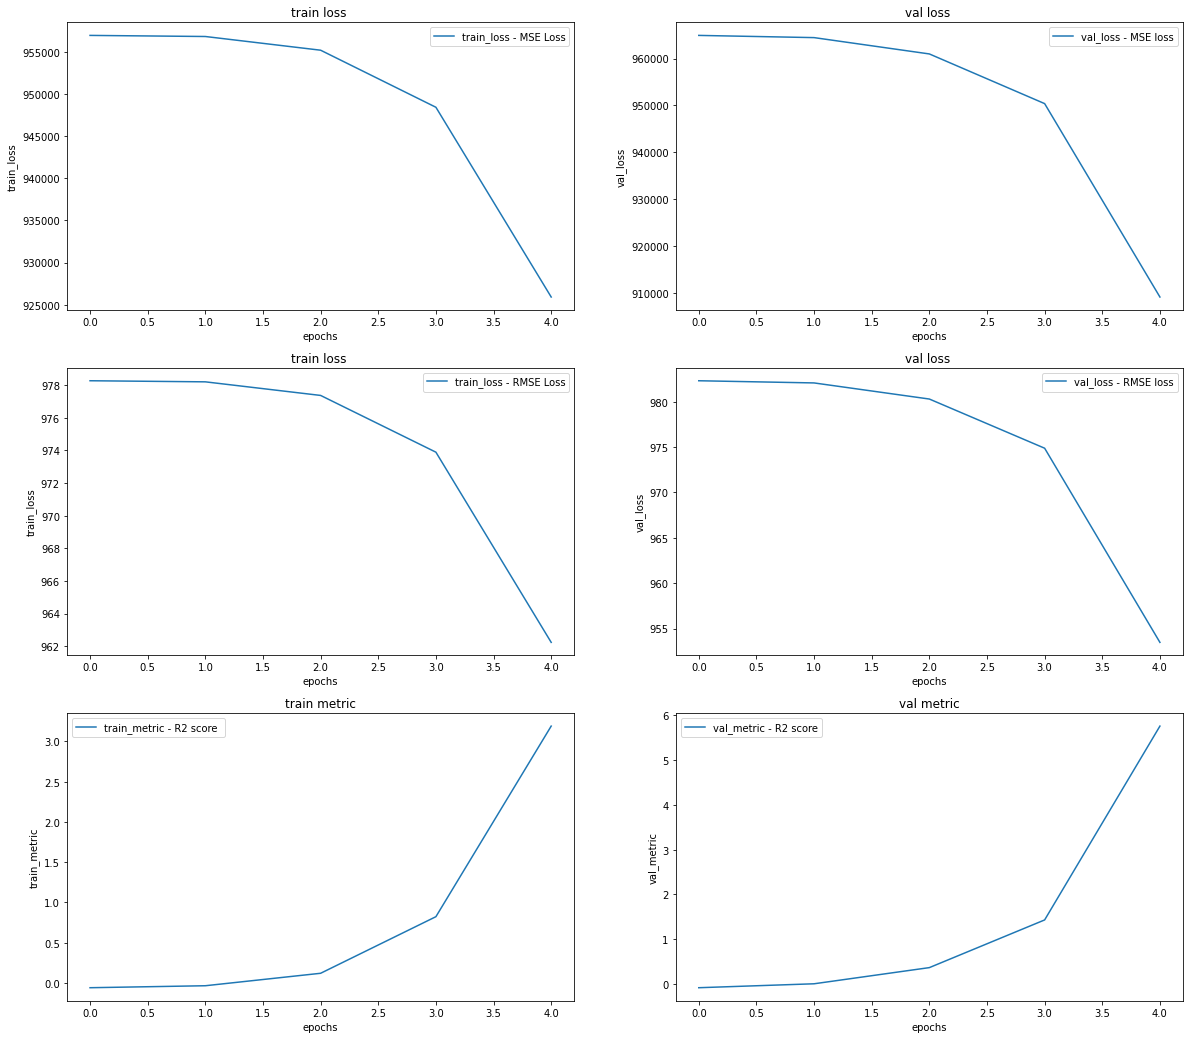

In [428]:
rnn_trainer_2.plot_data(*history_data_2)

## Testing Model

In [162]:
class test_model(): 

    def __init__(self, model = RNN_Model_1, test_dataloader = test_dataloader, ) :

        self.model = model.eval().to(device)
        self.test_dataloader = test_dataloader
    
    def get_prediction(self, save_path = None):

        # to store numpy array of predicted masks
        prediction = []
        truth_target = []

        with torch.no_grad():

            loop_obj = tqdm( enumerate(self.test_dataloader), desc = 'test images' , total = len(self.test_dataloader) )

            for index,batch in loop_obj :

                data,truth = batch

                # changing type and data type of the data to ensure computability
                data = data.to(device).type(torch.float32)

                predicted_target = self.model(data) 

                prediction.append( predicted_target.detach().cpu().numpy().squeeze(1) )
                truth_target.append( truth.detach().cpu().numpy().squeeze(1) )

                # print(masks[0].shape)
                # break
        
        self.test_prediction = np.concatenate(prediction)
        truth_target = np.concatenate(truth_target)

        return self.test_prediction,truth_target
    
    def plot_prediction(self,  pred, truth, n = 100):

        indexes = np.random.randint(0, len(truth), size = n)

        print('************************************************************************')
        print(f" r2_score of the test data is : {r2_score(truth,pred)*100:.2f} ")
        print(f" Mean Squared Error of the test data is : {mean_squared_error(truth,pred):.2f}")
        print(f" Root Mean Squared Error of the test data is : {mean_squared_error(truth,pred)**0.5:.2f}")
        print('************************************************************************')

        print(f" plotting goodness of fit of the test data with the given model of the random '{n}' data ")

        plt.figure( figsize=(20,12) )
        plt.plot(truth[indexes], '*' ,label = 'truth values', color = 'blue')
        plt.plot(pred[indexes], 'o' ,label = 'predicted values', color = 'orange' )
        plt.legend( loc = 'best')
        plt.title(' predicted vs truth of test data ')
        plt.show()

### testing model - 1

In [134]:
tester = test_model()
prediction, truth = tester.get_prediction()

test images: 100%|██████████| 28/28 [00:01<00:00, 19.26it/s]


************************************************************************
 r2_score of the test data is : 93.80 
 Mean Squared Error of the test data is : 58772.54
 Root Mean Squared Error of the test data is : 242.43
************************************************************************
 plotting goodness of fit of the test data with the given model of the random '100' data 


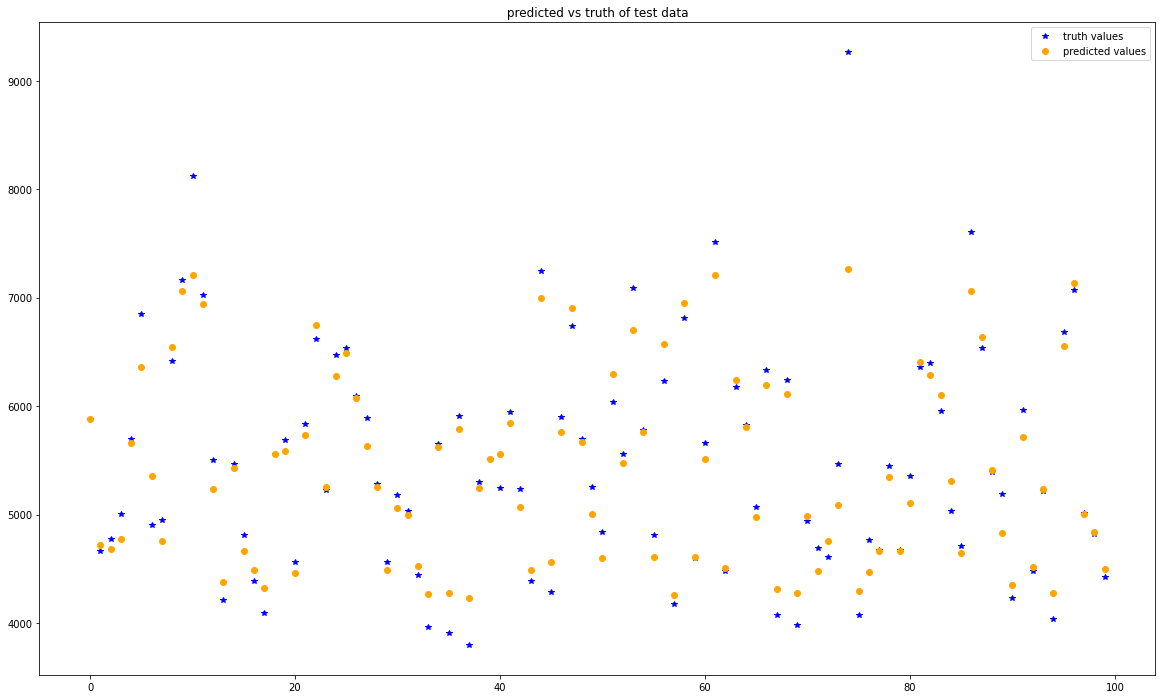

In [144]:
tester.plot_prediction(prediction , truth, n = 100 )

### testing model - 2

In [164]:
tester_2 = test_model(model = RNN_Model_2, test_dataloader = test_dataloader_2)
prediction, truth = tester_2.get_prediction()

test images: 100%|██████████| 11/11 [00:00<00:00, 14.07it/s]


************************************************************************
 r2_score of the test data is : 53.31 
 Mean Squared Error of the test data is : 448654.88
 Root Mean Squared Error of the test data is : 669.82
************************************************************************
 plotting goodness of fit of the test data with the given model of the random '100' data 


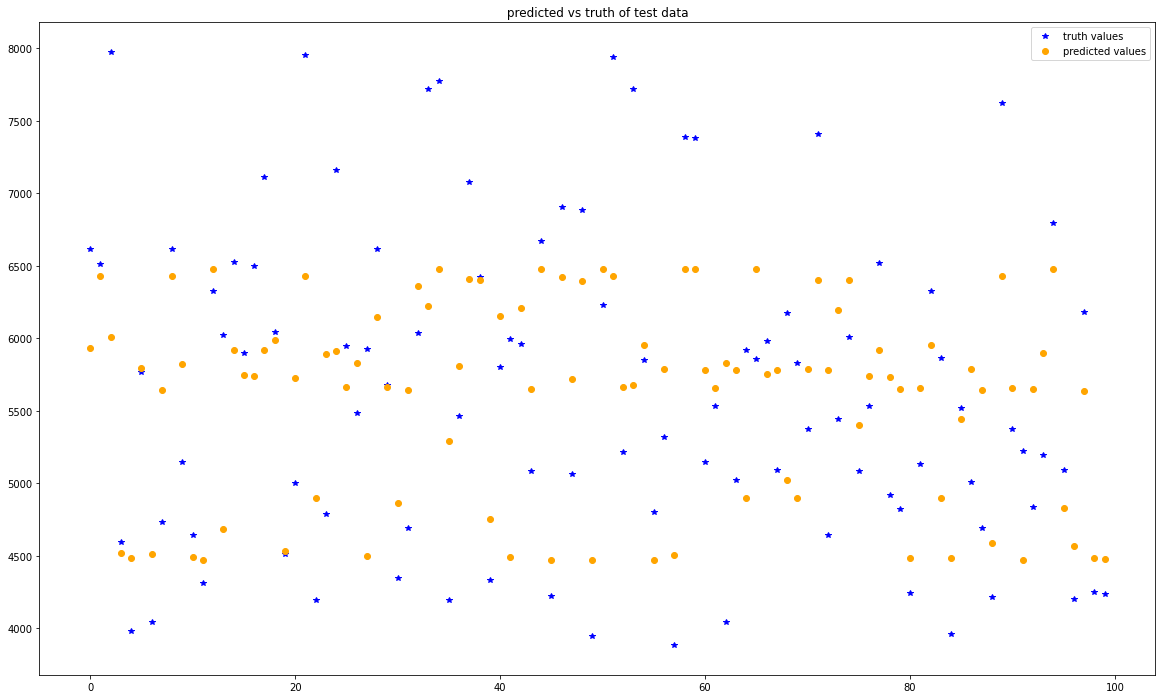

In [165]:
tester_2.plot_prediction(prediction , truth, n = 100 )

### Conclusion

Therefore we are able to see that our ***model - 1 able to perform well better than model - 2 trained with dataset of year and days*** 

***Dataset - 1 is better feature engineered than dataset - 2***

***`Previous Hundred values are much useful in predicting the target value ( Gives R2 score of around 90 to 95 in validation dataset after 30 epochs ) `***

***`But Dataset 2 with year month and day only able to give at-max able around 50% in R2 score after 30 epochs `***